# Dynamic Watering Point Localization for Soil Channeling Prevention Using Computer Vision
Teng Tian

In [1]:
%matplotlib inline
#import library
from plantcv import plantcv as pcv
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
#import time library to measure the execution time
import time
import math
import random

In [2]:
# automaticly show image after every process
pcv.params.debug="plot"

The images used in this work were captured by the on-board camera of Farmbot and were taken in the University Greenhouse.

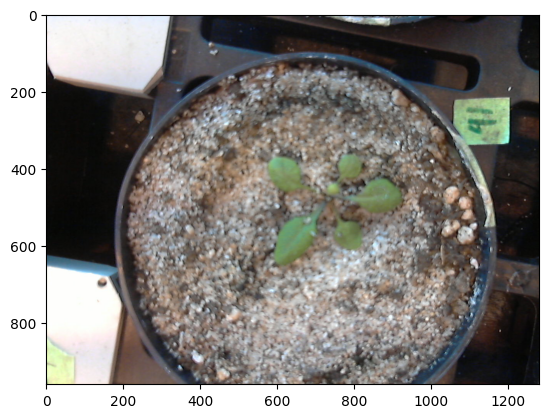

In [3]:
# read an image
img,path,filename=pcv.readimage(filename="../data/CAM_greenhouse/fotos_ideal_condition/Farmbot_GH_ideal_11.jpg", mode="rgb")

## Step 1: finde the location of the plants
Analyzing the image in different color spaces provides a clear understanding of the image properties.
#### (*)brief introduction to HSV and LAB color space

Here are the three components of the ***HSV color space***:

- Hue (H): Represents the type of color, often described as the dominant wavelength. It's typically measured in degrees, with 0° and 360° both representing red, 120° representing green, and 240° representing blue, creating a circular spectrum.
- Saturation (S): Refers to the intensity or vividness of the color. A saturation value of 0 indicates a shade of gray, while higher values represent more vibrant and saturated colors. Saturation is often expressed as a percentage.
- Value (V) or Brightness (B): Represents the brightness or lightness of the color. A value of 0 is completely black, and a value of 1 (or 100%) is fully illuminated or bright. Values between 0 and 1 represent various shades of color intensity.

The HSV color space is particularly useful for color selection and adjustment in graphics and image processing applications because it separates the color information into components that are more perceptually meaningful to humans.The HSV color space is not device-dependent, making it more suitable for certain applications, such as graphic design and image editing. However, it's important to note that the perceptual differences between colors in the HSV space are not always consistent across the entire range, unlike the LAB color space, which is designed for perceptual uniformity.


The ***LAB color space*** consists of three components:
- L (Lightness):* Represents the brightness of the color. It ranges from 0 (black) to 100 (white).
- a (Green to Red):* Represents the position of the color on the green to red axis. Positive values indicate red, and negative values indicate green.
- b (Blue to Yellow):* Represents the position of the color on the blue to yellow axis. Positive values indicate yellow, and negative values indicate blue.

The LAB color space is device-independent, meaning it is not tied to the characteristics of a specific device (like a monitor or printer), making it useful for color conversions between different devices.  This property makes LAB suitable for applications where accurate color reproduction and manipulation are crucial, such as in the field of image processing, color correction, and computer vision.

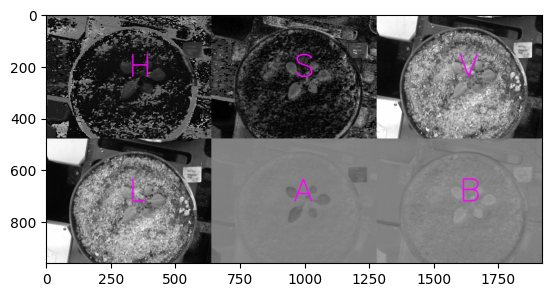

In [4]:
pcv.params.text_size = 8
pcv.params.text_thickness = 10
colorspaces=pcv.visualize.colorspaces(rgb_img=img, original_img=False)

The H channel refers to the color of objects in the image. I used the equalization function to make the difference easily visible to the human eye.
In the H channel, all the leaves of the plant have the same color value. The problem is that the soil particles also have some pigments with the same color value as the leaves, so they produce a lot of noise in the background. If we apply a binary threshold to this image, we can see this noise.

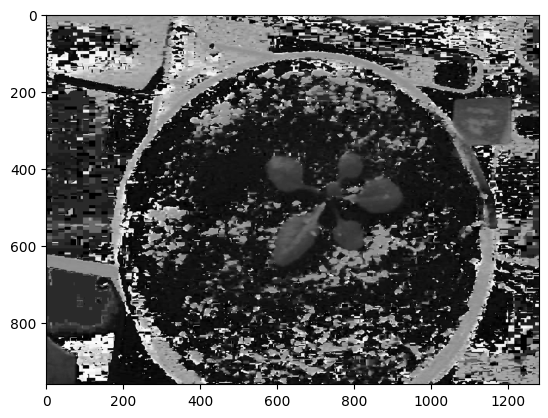

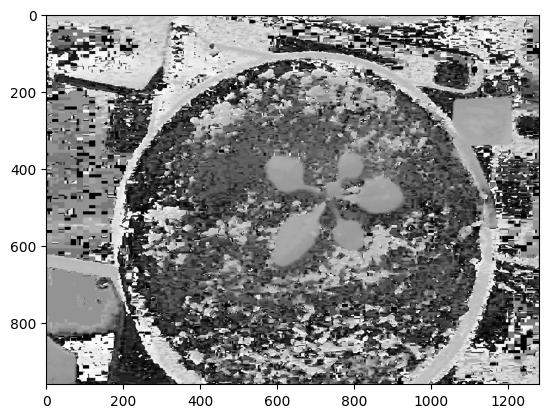

alt.Chart(...)

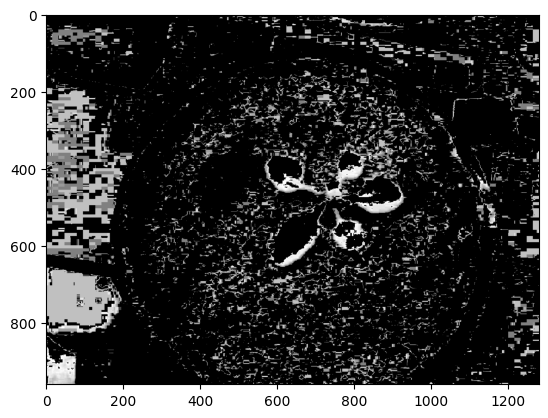

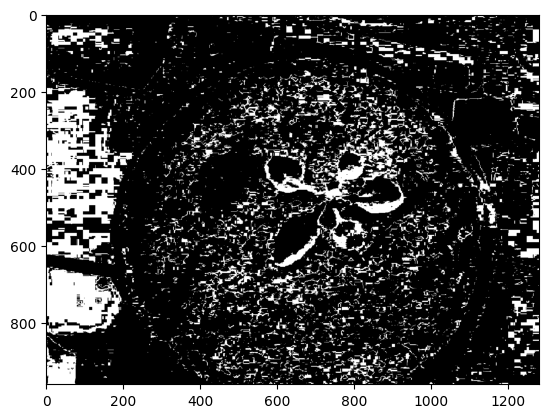

In [5]:
img_H=pcv.rgb2gray_hsv(rgb_img=img, channel="H")
img_H_hist_EQU=pcv.hist_equalization(img_H)
pcv.visualize.histogram(img=img_H)
img_H_thresh, __ = pcv.threshold.custom_range(img=img_H, lower_thresh=[20], upper_thresh=[40], channel='gray')

Using channel A will provide the most significant color difference between plants and the soil beneath. The plants appear to have a darker color.

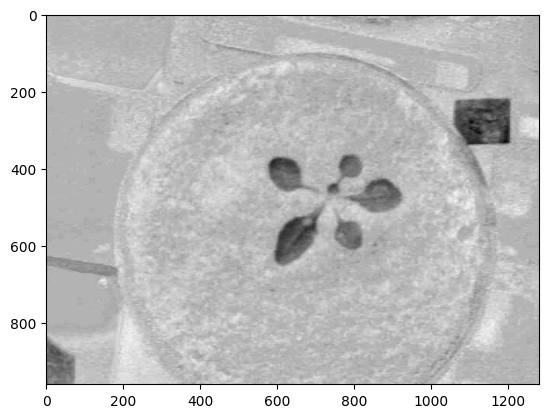

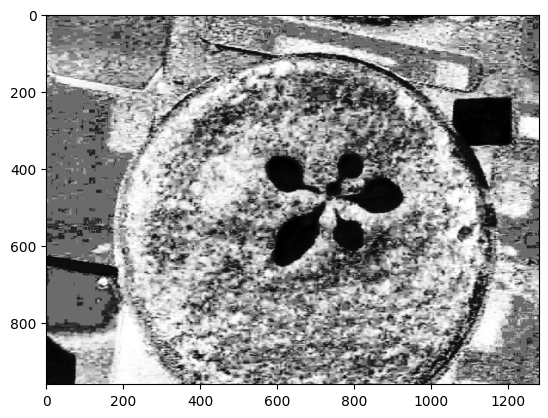

alt.Chart(...)

alt.Chart(...)

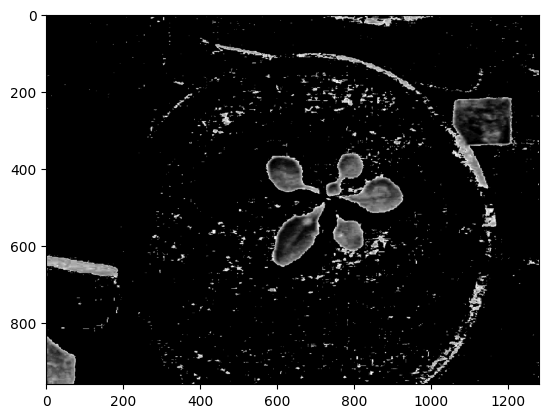

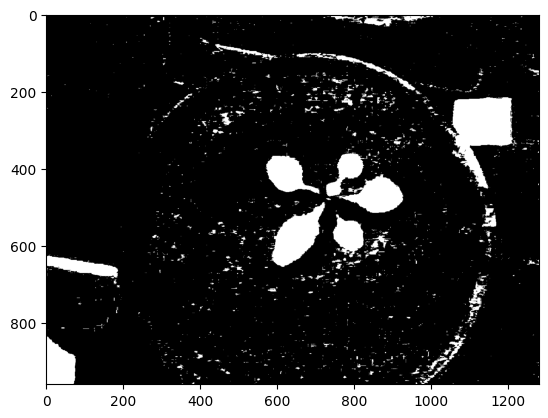

In [6]:
img_A=pcv.rgb2gray_lab(rgb_img=img, channel="A")
img_A_hist_EQU=pcv.hist_equalization(img_A)
pcv.visualize.histogram(img=img_A)
pcv.visualize.histogram(img=img_A_hist_EQU)
img_A_thresh, __ = pcv.threshold.custom_range(img=img_A_hist_EQU, lower_thresh=[0], upper_thresh=[30], channel='gray')

The V channel refers to the brightness of the objects. This can be used to eliminate all white spots caused by reflections from metal surfaces. We can also eliminate the dark background, which is the pallet holding the flower pots.

In [7]:
pcv.params.debug="none"
img_V=pcv.rgb2gray_hsv(rgb_img=img, channel="V")
img_V_thresh_up = pcv.threshold.binary(gray_img=img_V, threshold = 250, object_type='dark')
img_V_thresh_down = pcv.threshold.binary(gray_img=img_V, threshold = 50, object_type='light')
img_V_thresh = cv.bitwise_and(img_V_thresh_up,img_V_thresh_down)
pcv.params.debug="plot"

Let's put all of our masks from the H, A, and V channels together.

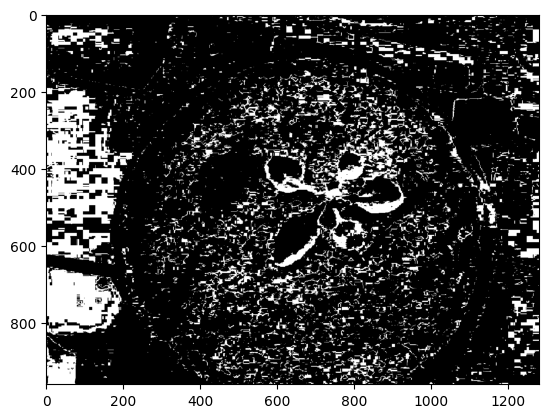

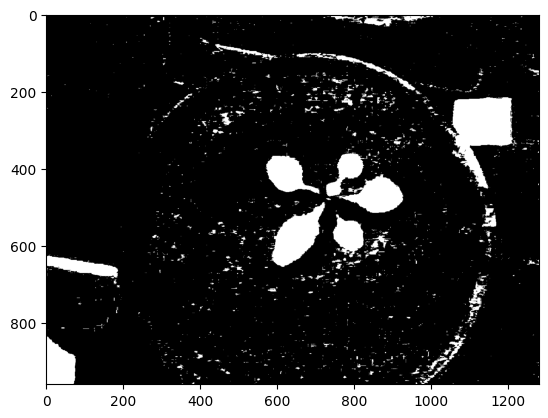

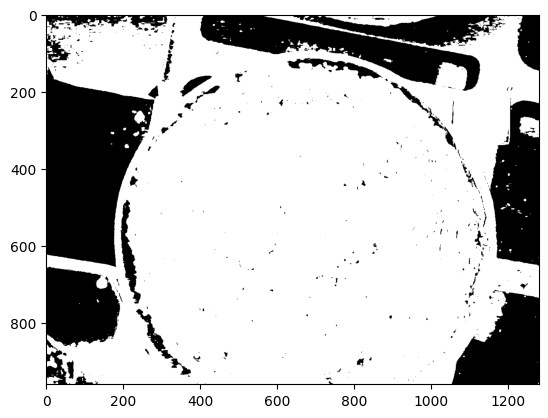

In [8]:
# in this way we habe now a binary mask
pcv.params.debug="none"

pcv.plot_image(img_H_thresh)
pcv.plot_image(img_A_thresh)
pcv.plot_image(img_V_thresh)

pcv.params.debug="plot"

To reduce noise in the H and A channel, we can use an erode method.
Afterward, the H and A masks can be combined by performing an OR-operation. The dark objects and bright spot can be eliminated by performing an AND-operation with the V mask.
As a result, the noise is mostly reduced.


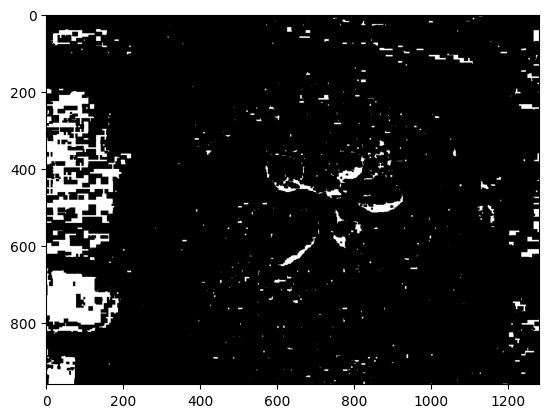

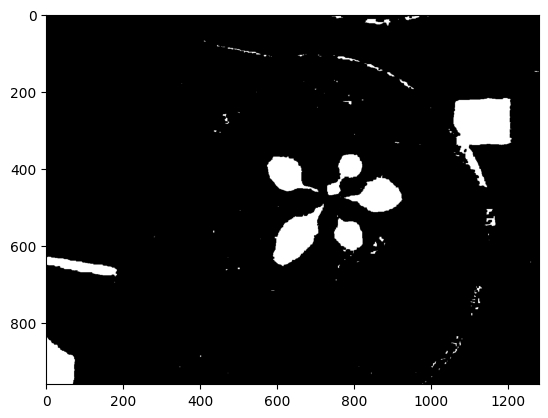

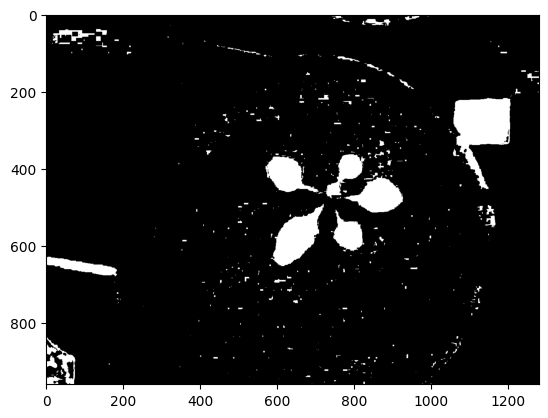

In [9]:
img_H_thresh_erode = pcv.erode(gray_img = img_H_thresh, ksize = 5, i = 1)
img_A_thresh_erode = pcv.erode(gray_img = img_A_thresh, ksize = 5, i = 1)
img_thresh = cv.bitwise_or(img_A_thresh_erode,img_H_thresh_erode)
img_thresh = cv.bitwise_and(img_thresh,img_V_thresh)
pcv.plot_image(img_thresh)

Using the closing method to improve the accuracy of the region-finding method.

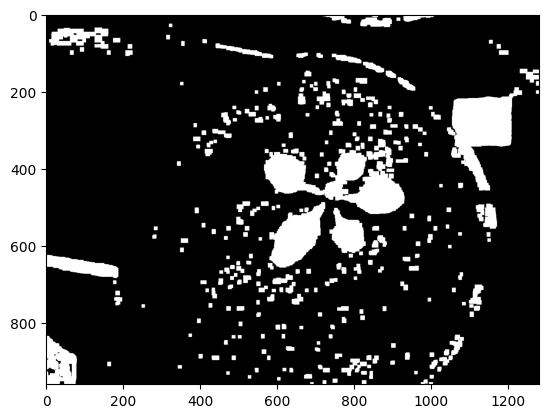

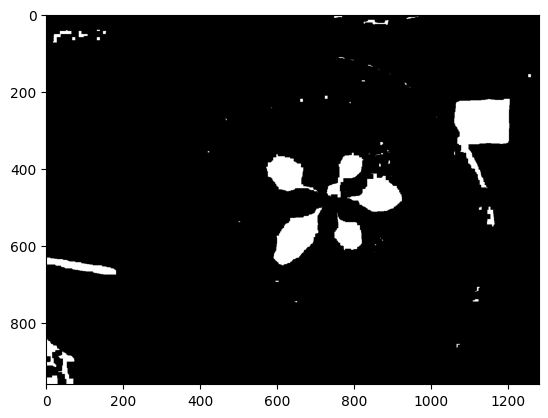

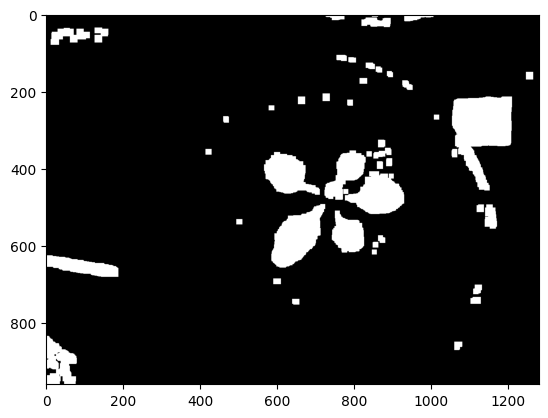

(960, 1280)


In [10]:
mask_dilated = pcv.dilate(gray_img = img_thresh, ksize = 5, i = 2)
mask_erode = pcv.erode(gray_img = mask_dilated, ksize = 5, i =3)
mask_dilated = pcv.dilate(gray_img = mask_erode, ksize = 5, i = 3)
mask = mask_dilated
print(np.shape(mask))

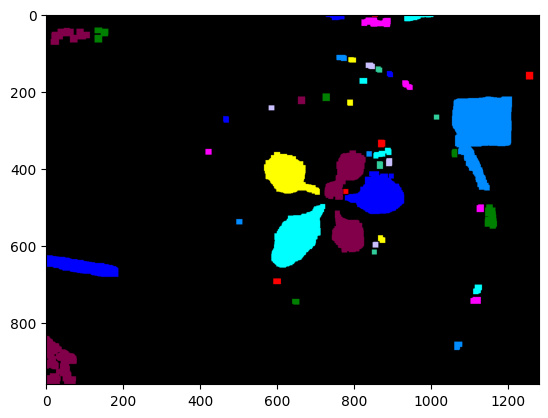

total 47 region(s) found!


In [11]:
# labeled the regions on the mask image
labeled_mask, num_mask = pcv.create_labels(mask=mask)
#pcv.plot_image(labeled_mask)
print('total', num_mask, 'region(s) found!')

The small regions that were found are more likely a result of remaining noise in the background. In this case, it would be acceptable to only consider the larger regions.

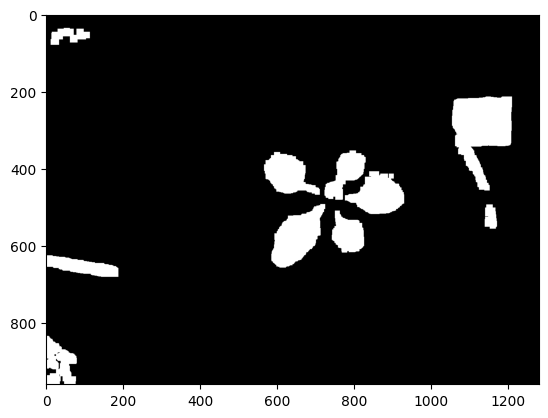

In [12]:
# just keep the first 10 biggst region on the mask
count = 0
region_info={}
for region_id in range(1,num_mask+1,1):
    mask_region_cnt = cv.inRange(labeled_mask,region_id,region_id)
    count = cv.countNonZero(mask_region_cnt)
    region_info[region_id]= (region_id, count)
list_of_region = list(region_info.values())
sorted_data = sorted(list_of_region, key=lambda x: x[1], reverse=True)
sorted_data_cop = sorted_data[:10]

mask_cop = np.zeros(np.shape(mask),dtype=np.uint8)
for region_id in sorted_data_cop:
    id = (int)(region_id[0])
    mask_cop+=cv.inRange(labeled_mask,id,id)

pcv.plot_image(mask_cop)

In [13]:
# just keep the biggst region on the mask
'''
region_info={}
count_prev = 0
count = 0
for region_id in range(1,num_mask+1,1):
    mask_region_cnt = cv.inRange(labeled_mask,region_id,region_id)
    count = cv.countNonZero(mask_region_cnt)
    contours_draw, hierarchy = cv.findContours(mask_region_cnt,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    arcLength_contour = cv.arcLength(contours_draw[0], True)
    if arcLength_contour > 5000: # This depends on the flower pot
        next
    elif count>count_prev:
        mask_cop = mask_region_cnt
        count_prev = count
    else:
        next
pcv.plot_image(mask_cop)
'''

'\nregion_info={}\ncount_prev = 0\ncount = 0\nfor region_id in range(1,num_mask+1,1):\n    mask_region_cnt = cv.inRange(labeled_mask,region_id,region_id)\n    count = cv.countNonZero(mask_region_cnt)\n    contours_draw, hierarchy = cv.findContours(mask_region_cnt,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)\n    arcLength_contour = cv.arcLength(contours_draw[0], True)\n    if arcLength_contour > 5000: # This depends on the flower pot\n        next\n    elif count>count_prev:\n        mask_cop = mask_region_cnt\n        count_prev = count\n    else:\n        next\npcv.plot_image(mask_cop)\n'

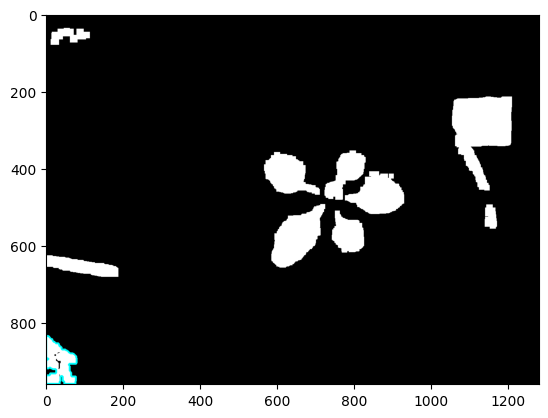

In [14]:
# calculation the center of mass of the region
# this will locate the plant
contours, hierarchy = cv.findContours(mask_cop,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
'''cnt = contours[0]
M = cv.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx,cy)
mask_RGB=cv.cvtColor(mask_cop,cv.COLOR_GRAY2BGR)
cv.circle(mask_RGB,(cx,cy),2,(0,255,0),20)
pcv.plot_image(mask_RGB)
'''
mask_RGB=cv.cvtColor(mask_cop,cv.COLOR_GRAY2BGR)
cv.drawContours(mask_RGB, contours, 0, (255,255,0), 3)
pcv.plot_image(mask_RGB)

Now we have a fairly accurate mask that shows where the plants are located.

## Step 2: Determine the inner area of the flower pot
The hough-circle method is being used to detect flower pots in the image. As a prerequisite, it is necessary to determine the minimum distance between two pots and the pot radius in pixels. This refers to these parameters:
- mindDist
- minRadius
- maxRadius

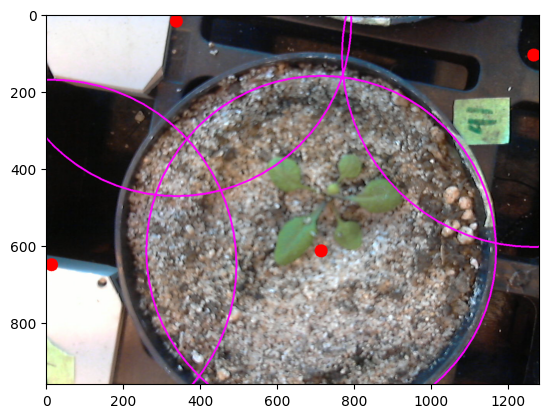

Execution time: 0.74 seconds


In [15]:
# using hough-circle to dectect flower pot(s) in the image
# as a precondition, we need to know the smallest distance between two pots and the radius of the pot in pixel
'''
cv.HoughCircles (image, circles, method, dp, minDist, param1 = 100, param2 = 100, minRadius = 0, maxRadius = 0)

Parameters
image	8-bit, single-channel, grayscale input image.
circles	output vector of found circles(cv.CV_32FC3 type). Each vector is encoded as a 3-element floating-point vector (x,y,radius) .
method	detection method(see cv.HoughModes). Currently, the only implemented method is HOUGH_GRADIENT
dp	inverse ratio of the accumulator resolution to the image resolution. For example, if dp = 1 , the accumulator has the same resolution as the input image. If dp = 2 , the accumulator has half as big width and height.
minDist	minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
param1	first method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
param2	second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
minRadius	minimum circle radius.
maxRadius	maximum circle radius.
'''
img_HoughCircles = img.copy()
start_time = time.time()
circles_list = []
img_GRAY=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
img_mB = cv.medianBlur(img_GRAY,5)
circles= cv.HoughCircles(image=img_mB,method=cv.HOUGH_GRADIENT,dp=4,minDist=700,param1=60,param2=40,minRadius=450,maxRadius=500)
circles = np.uint16(np.around(circles))
circles_list.append(circles)
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(img_HoughCircles,(i[0],i[1]),i[2],(255,0,255),4)
    # draw the center of the circle
    cv.circle(img_HoughCircles,(i[0],i[1]),2,(0,0,255),30)
pcv.plot_image(img_HoughCircles)
end_time = time.time()
print('Execution time:', round(end_time - start_time, 2), 'seconds')

The Hough Circle algorithm may find more than one circle in the image. The circle we are searching for is among them, and this is the most crucial aspect. The next step is to select the filter to exclude incorrect circles.
As a filtering criterion, we calculate the distance from the center of the circle to the center of the picture.

Distance to  1 . circle = 153
Distance to  2 . circle = 648
Distance to  3 . circle = 729
Distance to  4 . circle = 551
The 1 circle is the wanted circle
Position of the flowerpot is x= 714 y= 614 radius= 454


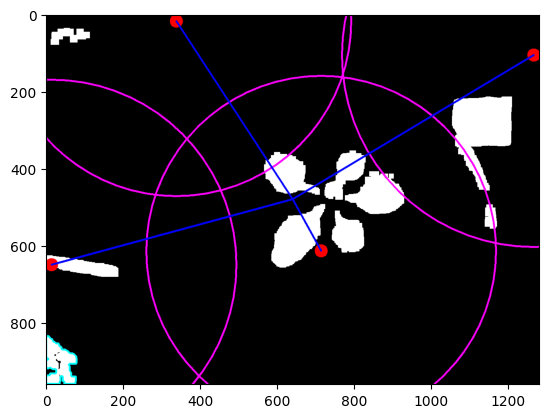

In [16]:
# we take only the circle, whose center is closest to center of the image 
cnt = 1
index = 0
distance_prev = 0
cy = (int)(np.shape(img)[0]/2)
cx = (int)(np.shape(img)[1]/2)
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(mask_RGB,(i[0],i[1]),i[2],(255,0,255),4)
    # draw the center of the circle
    cv.circle(mask_RGB,(i[0],i[1]),2,(0,0,255),30)
    # draw a line from the center of the circle to center of mass
    cv.line(mask_RGB,(i[0],i[1]), (cx,cy),(255,0,0),4)
    distance = (int)(math.sqrt((cx-i[0])**2+(cy-i[1])**2))
    if distance<distance_prev:
        index = cnt - 1
    print('Distance to ',cnt,'. circle =', distance)
    cnt=cnt+1
print('The',index+1, 'circle is the wanted circle')
pot_x = circles[0][index][0]
pot_y = circles[0][index][1]
pot_radius = circles[0][index][2]
print('Position of the flowerpot is', 'x=', pot_x,'y=',pot_y,'radius=',pot_radius)
pcv.plot_image(mask_RGB)

# Step 3: Setting watering points
Now we know the exact location of the plants and the pot. The area in the pot can be divided for dynamic watering.

I utilized a straightforward method. An edge area was set to prevent water from flowing out of the pot and to prevent soil channels from forming at the edge of the pot. The pot is divided into 12 parts and checked for plant leaves. If there are no leaves, a watering point is set in the area.

The mask will be enlarged on purpose to create a safe zone, so that the watering point will not be set on the edge of the leaves.

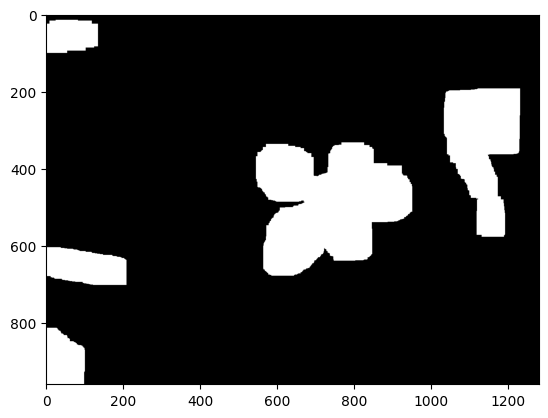

In [18]:
# let us define the watering point.
# It cannot be at the edge area, and either on top of the plant
# the point will be randomly picked, and store in a list
edge_area = 150 # 100 Pixel to the edge will not be watered
num_watering_points = 4*7 # 4 times a day and 7 days a week
# create watering point
#angel = 30 # must be 15, 30, 45, 60, 90
# the previous mask will be enlarged, so that there will be a safty zone, that we will not water the leaves
mask_with_saftyzone = pcv.dilate(gray_img = mask_cop, ksize = 15, i = 3)
watering_points_list = [] # this list will store the coordinates of the watering points
count = 0
while (count<=num_watering_points):
    angel = random.randint(0,360)
    rel_radius = random.random()
    x_watering_point = (int)(math.cos(angel/180*math.pi)*(pot_radius - edge_area)*rel_radius+pot_x)
    y_watering_point = (int)(math.sin(angel/180*math.pi)*(pot_radius - edge_area)*rel_radius+pot_y)
    if mask_with_saftyzone[y_watering_point, x_watering_point] != 255:
        watering_points_list.append((x_watering_point, y_watering_point))
        count+=1
    #watering_point_list.append((x_watering_point, y_watering_point))

prossible watering point: (952, 567)
prossible watering point: (710, 705)
prossible watering point: (666, 725)
prossible watering point: (772, 720)
prossible watering point: (464, 725)
prossible watering point: (514, 541)
prossible watering point: (896, 371)
prossible watering point: (832, 334)
prossible watering point: (894, 642)
prossible watering point: (972, 524)
prossible watering point: (819, 723)
prossible watering point: (956, 431)
prossible watering point: (865, 598)
prossible watering point: (618, 732)
prossible watering point: (436, 737)
prossible watering point: (616, 497)
prossible watering point: (838, 701)
prossible watering point: (842, 820)
prossible watering point: (474, 571)
prossible watering point: (706, 674)
prossible watering point: (692, 670)
prossible watering point: (708, 674)
prossible watering point: (699, 826)
prossible watering point: (563, 632)
prossible watering point: (735, 635)
prossible watering point: (532, 594)
prossible watering point: (968, 448)
p

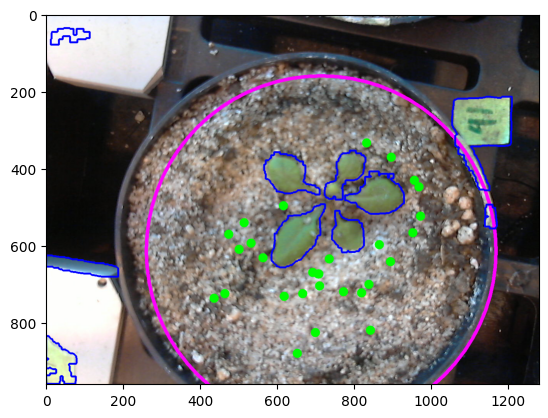

In [20]:
# lets draw everything on image
img_out = img.copy()
cv.circle(img_out,(pot_x,pot_y),pot_radius,(255,0,255),8)
for i in watering_points_list:
    cv.circle(img_out,i,2,(0,255,0),20)
    print('prossible watering point:',i)
cv.drawContours(img_out, contours, contourIdx=-1, color=(255,0,0), thickness=3)
pcv.plot_image(img_out)